In [32]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [2]:
def getRefSignal(f0,duration,sr, phi=0):
    # single-tone with frequency "f0" and duration "duration"
    # "sr" is the sampling rate
    Ns = duration * sr
    # t = np.r_[0.0:Ns]/sr
    t = np.arange(int(Ns))/sr
    return np.sin(2*np.pi*f0*t + phi)

def noncoherence(sig,refSignal1,refSignal2):
    # non-coherence method: use both sin and cos reference signals
    autoc1 = np.correlate(sig, refSignal1, mode = 'valid')
    autoc2 = np.correlate(sig, refSignal2, mode = 'valid')
    autoc = np.sqrt((autoc1*autoc1 + autoc2*autoc2)/2)
    return autoc

In [3]:
CHUNK = 64
f0 = 25000
duration=0.004
RATE=64000
THRESHOLD = 7000
RefSignal = getRefSignal(f0,duration,RATE, 0)
RefSignal2 = getRefSignal(f0,duration,RATE, np.pi/2)

In [4]:
len(RefSignal)

256

In [5]:
raw = np.fromfile('single_tone_v2.dat', dtype=np.int32)
x = raw>>14

In [10]:
sig = noncoherence(x, RefSignal, RefSignal2) 

In [27]:
width = 4e-3
f = 25000
fs = 64000
t = np.arange(fs*width) / fs

cosine = np.cos(2*np.pi*f*t)
sine = np.sin(2*np.pi*f*t)

c_cross = np.correlate(x, cosine)
s_cross = np.correlate(x, sine)
crossP = c_cross*c_cross + s_cross*s_cross

<IPython.core.display.Javascript object>


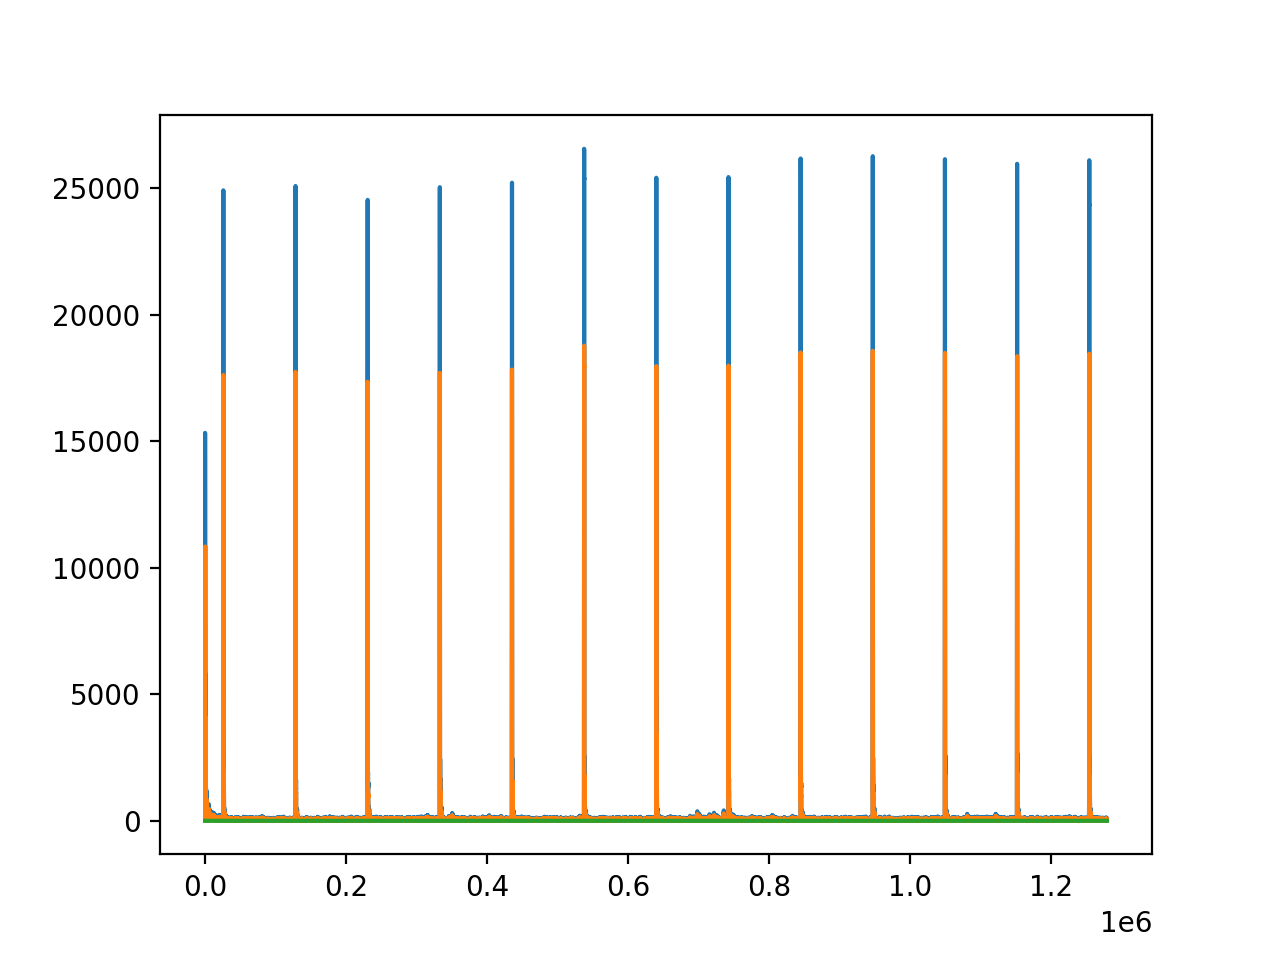

In [28]:
%matplotlib notebook
plt.figure()
plt.plot(crossP**0.5)
plt.plot(sig)

In [29]:
len(crossP)

1279745

In [33]:
@jit
def sg_v2(x, k=25*4):
    Pxx = []
    N = 64*4
    w = 2*np.pi*k/N;
    cw = np.cos(w);
    c = 2*cw;
    sw = np.sin(w);
    z1=0;
    z2=0;
    #while (idx < (len(x)-1)):
    for idx in range(len(x)):
        if idx<N:
            z0 = x[idx] + c*z1 - z2;
        else:
            z0 = x[idx] - x[idx-N] + c*z1 -z2;
        z2 = z1;
        z1 = z0;

        P = z2*z2 + z1*z1 - c * z1*z2
        Pxx.append(P)
    return np.array(Pxx)

In [34]:
g = sg_v2(x, k=100)

In [41]:
len(g[255:]), len(crossP)

(1279745, 1279745)

<IPython.core.display.Javascript object>


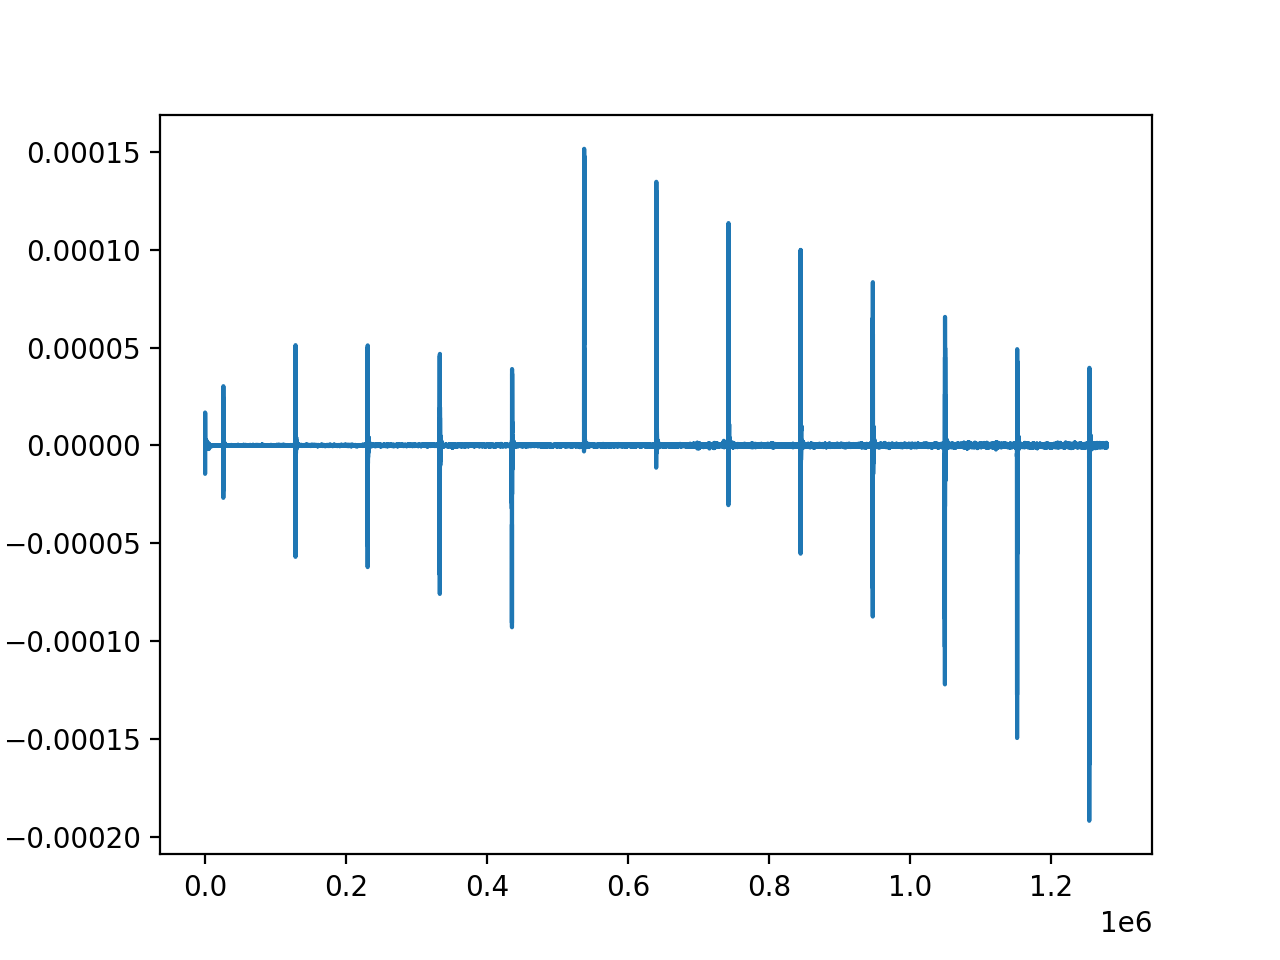

In [44]:
plt.figure()
plt.plot(g[255:] - crossP)
